## <Center> Classification with Naive Bayes
    
<Center><author> Zander Bonnet
    
<center><Date> Aug 21, 2024

I selected the Recipe Reviews and User Feedback dataset from the UCI machine learning repository. This dataset is a repository of user responses to recipes. It is ethically sourced as all the data comes from voluntary responses.

The data set contains a variety of factors, but we will only use two for this project. The two that we will use are the number of stars a recipe is given, and the text review that they leave.

By applying Naive Bayes I hope to use the verbiage of one's review to predict the number of stars that they gave the recipe. The algorithm can do this by taking the unique words in all of the responses and calculating the probability that the word will show up in a specific category of reviews. The algorithm can then calculate the probability that a specific response is in one group or another and choose the most probable outcome. The major fault of this algorithm is that it assumes that all the input values are independent, when in reality that is probably not the case.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import text

import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
recipe_reviews_and_user_feedback = fetch_ucirepo(id=911) 
  
# data (as pandas dataframes) 
X = recipe_reviews_and_user_feedback.data.features 
y = recipe_reviews_and_user_feedback.data.targets 
  
# metadata 
print(recipe_reviews_and_user_feedback.metadata) 
  
# variable information 
print(recipe_reviews_and_user_feedback.variables) 

{'uci_id': 911, 'name': 'Recipe Reviews and User Feedback', 'repository_url': 'https://archive.ics.uci.edu/dataset/911/recipe+reviews+and+user+feedback+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/911/data.csv', 'abstract': 'The "Recipe Reviews and User Feedback Dataset" is a comprehensive repository of data encompassing various aspects of recipe reviews and user interactions. It includes essential information such as the recipe name, its ranking on the top 100 recipes list, a unique recipe code, and user details like user ID, user name, and an internal user reputation score.\n\nEach review comment is uniquely identified with a comment ID and comes with additional attributes, including the creation timestamp, reply count, and the number of up-votes and down-votes received. Users\' sentiment towards recipes is quantified on a 1 to 5 star rating scale, with a score of 0 denoting an absence of rating.\n\nThis dataset is a valuable resource for researchers and data scie

In [3]:
X.isna().sum()

num_records        0
recipe_number      0
recipe_code        0
recipe_name        0
comment_id         0
user_id            0
user_name          0
user_reputation    0
created_at         0
reply_count        0
thumbs_up          0
thumbs_down        0
stars              0
best_score         0
text               2
dtype: int64

In [4]:
#drop missing values
X = X.dropna()
X = X.reset_index(drop = True)

#extract relevant columns
reviews = X[['stars', 'text']]

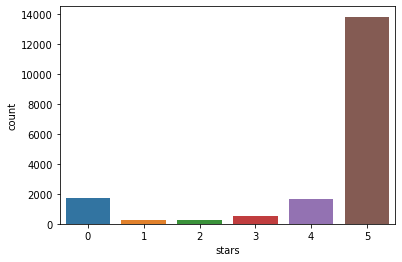

In [5]:
#show distrobution of reviews
sns.countplot(x = reviews['stars'])
plt.show()

In [6]:
#convert to 1 being a perfect recipe or 0 being less then that
reviews.loc[:,'stars'] = reviews['stars'].apply(lambda x: 1 if x > 4 else 0)

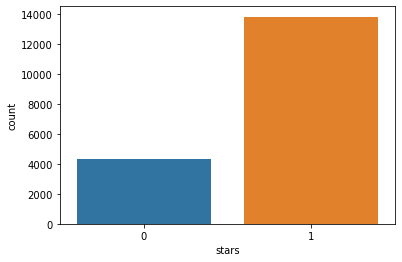

In [7]:
sns.countplot(x = reviews['stars'])
plt.show()

In [8]:
print(f"Proportion of low ratings: {'{:.2f}%'.format(sum(reviews['stars'] == 0)/len(reviews['stars'])*100)}")

Proportion of low ratings: 23.94%


I removed the missing data as there were only two missing points. When looking at the data there is an extreme difference in size of the groups. To combat this I chose to split the data into perfect ratings, and then less favorable ratings. This will help close the gap, but we still might face problems with the model favoring the dominant group.

How accurately can we predict if a user gave a perfect rating, based on their typed response?

Will the discrepancy in the size of the classes cause the model to favor the more common group?

In [9]:
#Clean the text
stop = stopwords.words('english')

# Tokenize
reviews.loc[:,'tokens'] = reviews.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)

# Remove stop words
reviews.loc[:,'tokens'] = reviews['tokens'].apply(lambda x: [item for item in x if item not in stop])

# Apply Porter stemming
stemmer = PorterStemmer()
reviews.loc[:,'tokens'] = reviews['tokens'].apply(lambda x: [stemmer.stem(item) for item in x])

In [10]:
# Unify the strings once again
reviews.loc[:,'tokens'] = reviews['tokens'].apply(lambda x: ' '.join(x))

X = reviews['tokens']
y = reviews['stars']

# Make split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= 0.2,random_state= 2000)
# Create vectorizer
vectorizer = text.CountVectorizer(strip_accents = 'ascii', lowercase = True)

# Fit vectorizer & transform it
vectorizer_fit = vectorizer.fit(X_train)
X_train_transformed = vectorizer_fit.transform(X_train)
X_test_transformed = vectorizer_fit.transform(X_test)

In [11]:
# Train the model
nb = MultinomialNB()
nb.fit(X_train_transformed, y_train)

MultinomialNB()

In [12]:
pred = nb.predict(X_train_transformed)

In [13]:
accuracy_score(y_train,pred)

0.8479785478547854

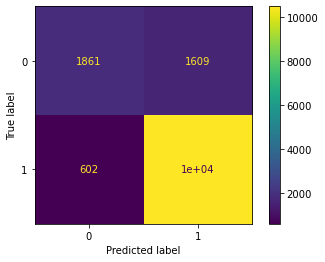

In [14]:
cm = confusion_matrix(y_train, pred)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()
plt.show()

In [15]:
pred = nb.predict(X_test_transformed)

In [16]:
accuracy_score(y_test,pred)

0.812981298129813

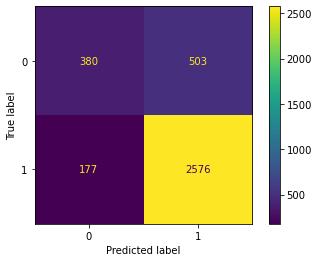

In [17]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()
plt.show()

The model accuracy shows that it is about 81% accurate in predicting if the user will rate a recipe a perfect 5 stars or not. We can also see in the confusion matrix for both the training data and the testing data that the model does tend to favor the 5-star classification. We can see this as the number of false positives is much higher than the number of false negatives.

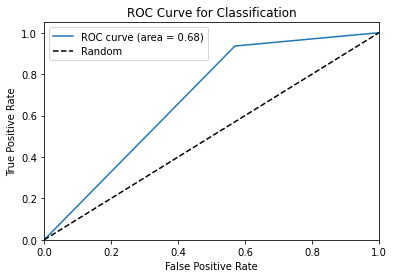

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)


plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification')
plt.legend()
plt.show()

The ROC-AUC curve shows that the model requires a very high false positive rate to obtain a good true positive rate. The AUC of .68 means that the model is only a little better than randomly assigning the data to a group.

In [19]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2000)
score = cross_val_score(MultinomialNB(),
                        X_train_transformed, y_train, cv = kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.80405638 0.80336886 0.80199381 0.79718116 0.81189821]
Average score: 0.80


In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=2000)
score = cross_val_score(MultinomialNB(),
                        X_train_transformed, y_train, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.80302509 0.80990031 0.81230663 0.79064971 0.80639615]
Average score: 0.80


When looking at the Kfold cross-validation scores both stratified and standard kfold result in a similar accuracy score of 80%. This means that even when we ensure that there is some data from the below 5 stars group, the 5 stars group dominates the results. 

Overall the does not perform very well, as it is overfit towards the 5-star reviews. The data needs to be more robust to make accurate models on overall ratings.

In the future, I might have chosen a different way to split the training and testing data. I might have chosen to train the data on an equal proportion between the two groups. This possibly would have removed some of the bias towards the larger class.

## <center> Reference
Ali,Amir, Matuszewski,Stanislaw , and Czupyt,Jacek. (2023). Recipe Reviews and User Feedback. UCI Machine Learning Repository. https://doi.org/10.24432/C5FG95.
    
Jauregui, A. F. (2022, August 16). Naive Bayes in python. https://anderfernandez.com/en/blog/naive-bayes-in-python/ 